## Dilution with Global Mechanisms
Global mechanisms provide a framework to have certain reactions work on specific subsets of species in a CRN, applied at the end of compilation to all species created by Component and Mixture Mechanisms.

Under the hood, global mechanisms work just like normal mechanisms - they take a set of species and compile them into CRNs. Global mechanisms are called at the end of the compilation, so they apply to all species generated by all local mechanisms. 

### Keywords:
__filter_dict__ {str : True/False} is used to make global mechanisms selective. The dictionaries keys (strings) can be species' names, types, or attributes. The mechanism is then applied or not based upon the value of that attribute in the filter_dict. For exampe filter_dict = {"dna":False} would not apply its mechanism to any "dna" species. 

__default_on__ True / False: For species with no attributes in the filter_dict, a global mechanism defaults to its default_on keyword, which can be True or False.

__recursive_species_filtering__ True / False: When applying a filter dictionary to a ComplexSpecies, this keyword determines if the filter will be applied recursively to all species inside that complex species. For example, consider the filter dict filter_dict = {"dna":False}. A ComplexSpecies (material_type="complex") consisting of a species of type material_type="dna" and a species of type material_type="protein" will not be effected by this filter unless recursive_species_filtering = True. Note that attributes are automatically inheritted recursively, so this keyword only matters for name and material_type filters.



## Example 1: Global Dilution using attributes

In the following example, a model will be set up where global mechanisms cause degredation by dilution on all species which are do not have the attributes "genomic" or "machinery"

Species (15) = {0. protein[RNAP(machinery)], 1. protein[Ribo(machinery)], 2. protein[RNAase(machinery)], 3. protein[G1], 4. rna[G1], 5. complex[dna[G1]:protein[RNAP](machinery)], 6. complex[protein[Ribo]:rna[G1](machinery)], 7. dna[G1], 8. complex[protein[RNAase]:rna[G1](machinery)], 9. complex[protein[Ribo]:rna[G2](machinery)], 10. rna[G2], 11. complex[dna[G2]:protein[RNAP](genomic, machinery)], 12. protein[G2], 13. complex[protein[RNAase]:rna[G2](machinery)], 14. dna[G2(genomic)]}
Reactions (17) = [
0. dna[G1] + protein[RNAP(machinery)] <--> complex[dna[G1]:protein[RNAP](machinery)]        
        massaction: k_f(dna[G1],protein[RNAP(machinery)])=100*dna[G1]*protein[RNAP(machinery)]
        k_r(complex[dna[G1]:protein[RNAP](machinery)])=20*complex[dna[G1]:protein[RNAP](machinery)]
1. complex[dna[G1]:protein[RNAP](machinery)] --> dna[G1] + rna[G1] + protein[RNAP(machinery)]        
        massaction: k_f(complex[dna[G1]:protein[RNAP](machinery)])=3*complex[dna[G1]:protein[RNAP](mach

C:\ProgramData\Anaconda3\lib\site-packages\html5lib\_trie\_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


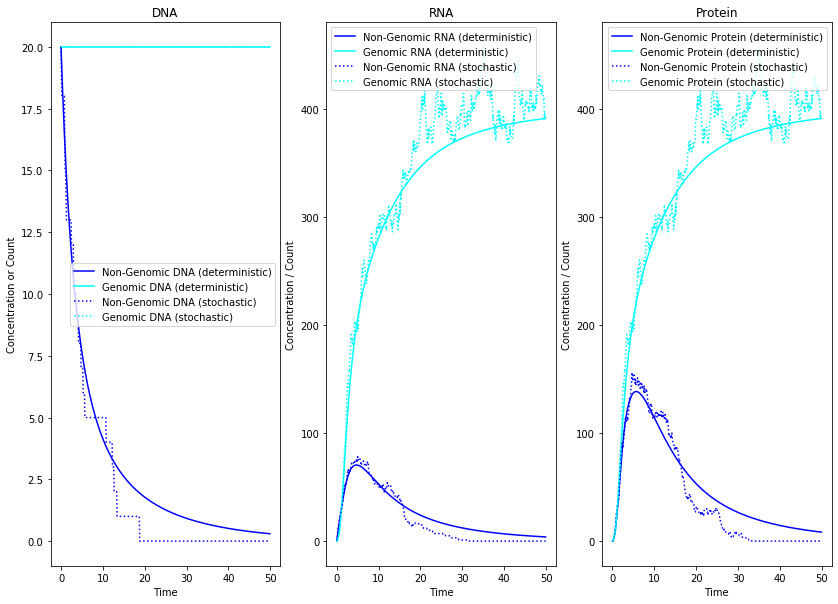

In [1]:
from biocrnpyler import *

#We will only use default parameters in this model, for simplicity.
kb, ku, ktx, ktl, kdeg, kdil = 100, 20, 3, 2, .5, .5
parameters = {"kb":kb, "ku":ku, "ktx":ktx, "ktl":ktl, "kdeg": kdeg, "kdil":kdil}

#Creates a global dilution mechanism that acts on all species generated except for
# those with the type or attribute "genome" or "machinery"
dilution_mechanism = Dilution(filter_dict = {"genomic":False, "machinery":False}, default_on = True)

#Add this mechanism to a dictionary which is passed into the Mixture txtl.TxTlExtract
global_mechanisms = {"dilution":dilution_mechanism}
myMixture = TxTlExtract(name = "txtl", parameters = parameters, global_mechanisms = global_mechanisms, parameter_warnings= False)

#Add machinery attributes to species I want constiutively expressed at the dilution rate
myMixture.rnap.add_attribute("machinery")
myMixture.rnaase.add_attribute("machinery")
myMixture.ribosome.add_attribute("machinery")

#Creates a dna assembly. This assembly is type "dna" so it will be degraded
A_dna = DNAassembly(name = "G1", promoter = "pBest", rbs = "BCD2")

#Create another dna assembly but set its internal specie's attributes to contain "genomic" so it will not be degraded
#Note: this only protects the dna_G2 species encoded by this assembly as well as complex species (eg rnap:DNA) which inherit their subspecies attributes.
A_genome = DNAassembly(name = "G2", promoter = "pBest", rbs = "BCD2", attributes = ["genomic"])


myMixture.add_components(A_dna)
myMixture.add_components(A_genome)
myCRN = myMixture.compile_crn()
print(myCRN.pretty_print(show_rates = True, show_materials = True, show_attributes = True))


print("Simulating with BioSCRAPE")
import numpy as np
import pylab as plt
timepoints = np.arange(0, 50, .1)

x0_dict = {repr(myMixture.ribosome.get_species()):100,
           repr(myMixture.rnap.get_species()):20,
           repr(myMixture.rnaase.get_species()):10,
           repr(A_dna.dna):20,
           repr(A_genome.dna):20}

full_result_sto = myCRN.simulate_with_bioscrape(timepoints, x0_dict, stochastic = True)
full_result_det = myCRN.simulate_with_bioscrape(timepoints, x0_dict, stochastic = False)

if (full_result_det is not None) and (full_result_sto is not None):
    #chemical_reaction_network.get_all_species_containing is a useful shortcut to get lists of species
    tot_A_dna_det = np.sum(full_result_det[myCRN.get_all_species_containing(A_dna.dna, return_as_strings=True)], 1)
    tot_A_genome_det = np.sum(full_result_det[myCRN.get_all_species_containing(A_genome.dna, return_as_strings=True)], 1)
    tot_A_dna_sto = np.sum(full_result_sto[myCRN.get_all_species_containing(A_dna.dna, return_as_strings=True)], 1)
    tot_A_genome_sto = np.sum(full_result_sto[myCRN.get_all_species_containing(A_genome.dna, return_as_strings=True)], 1)

    tot_A_dna_rna_det = np.sum(full_result_det[myCRN.get_all_species_containing(A_dna.transcript, return_as_strings=True)], 1)
    tot_A_genome_rna_det = np.sum(full_result_det[myCRN.get_all_species_containing(A_genome.protein, return_as_strings=True)], 1)
    tot_A_dna__rna_sto = np.sum(full_result_sto[myCRN.get_all_species_containing(A_dna.transcript, return_as_strings=True)], 1)
    tot_A_genome_rna_sto = np.sum(full_result_sto[myCRN.get_all_species_containing(A_genome.protein, return_as_strings=True)], 1)


    plt.figure(figsize = (14, 10))
    plt.subplot(131)
    plt.plot(timepoints, tot_A_dna_det, color = "blue", label = "Non-Genomic DNA (deterministic)")
    plt.plot(timepoints, tot_A_genome_det, color = "cyan", label = "Genomic DNA (deterministic)")
    plt.plot(timepoints, tot_A_dna_sto, ":", color = "blue", label = "Non-Genomic DNA (stochastic)")
    plt.plot(timepoints, tot_A_genome_sto, ":", color = "cyan", label = "Genomic DNA (stochastic)")
    plt.legend()
    plt.xlabel("Time")
    plt.title("DNA")
    plt.ylabel("Concentration or Count")

    plt.subplot(132)
    plt.plot(timepoints, tot_A_dna_rna_det, color = "blue", label = "Non-Genomic RNA (deterministic)")
    plt.plot(timepoints, tot_A_genome_rna_det, color = "cyan", label = "Genomic RNA (deterministic)")
    plt.plot(timepoints, tot_A_dna__rna_sto, ":", color = "blue", label = "Non-Genomic RNA (stochastic)")
    plt.plot(timepoints, tot_A_genome_rna_sto, ":", color = "cyan", label = "Genomic RNA (stochastic)")
    plt.legend()
    plt.xlabel("Time")
    plt.title("RNA")
    plt.ylabel("Concentration / Count")

    plt.subplot(133)
    plt.plot(timepoints, full_result_det[str(A_dna.protein)], color = "blue", label = "Non-Genomic Protein (deterministic)")
    plt.plot(timepoints, full_result_det[str(A_genome.protein)], color = "cyan", label = "Genomic Protein (deterministic)")
    plt.plot(timepoints, full_result_sto[str(A_dna.protein)], ":", color = "blue", label = "Non-Genomic Protein (stochastic)")
    plt.plot(timepoints, full_result_sto[str(A_genome.protein)], ":", color = "cyan", label = "Genomic Protein (stochastic)")
    plt.legend()
    plt.title("Protein")
    plt.xlabel("Time")
    plt.ylabel("Concentration / Count")

    plt.show()


## Example 2: Global Dilution using material_type with and without recursive_species_filtering

In this example a very simple model of a piece of DNA $G$ binding to a protein $P$ to form a complex will be considered. Dilution will be applied to all species excent those of type "dna". When recursive_species_filtering is False, the protein AND the DNA-protein complex are both diluted. When recursive_species_filtering is True, only the protein is diluted.

In [3]:
parameters = {"kb":kb, "ku":ku,"kdil":kdil}

G = Species("G", material_type = "dna")
A = Species("A", material_type = "protein")
C1 = ChemicalComplex([G, A])

dilution_mechanism_no_recursion = Dilution(filter_dict = {"dna":False}, default_on = True, recursive_species_filtering = False)
M_no_recursion = ExpressionExtract(components = [C1], global_mechanisms = {"dilution":dilution_mechanism_no_recursion}, parameters = parameters)
CRN_no_recursion = M_no_recursion.compile_crn()
print("CRN: recursive_species_filtering = False:\n", CRN_no_recursion)

dilution_mechanism_recursion = Dilution(filter_dict = {"dna":False}, default_on = True, recursive_species_filtering = True)
M_recursion = ExpressionExtract(components = [C1], global_mechanisms = {"dilution":dilution_mechanism_recursion}, parameters = parameters)
CRN_recursion = M_recursion.compile_crn()
print("\nCRN: recursive_species_filtering = True:\n", CRN_recursion)

CRN: recursive_species_filtering = False:
 Species = complex_dna_G_protein_A, dna_G, protein_A
Reactions = [
	complex_dna_G_protein_A -->         massaction: k_f(complex_dna_G_protein_A)=0.5*complex_dna_G_protein_A
	dna_G + protein_A <--> complex_dna_G_protein_A        massaction: k_f(dna_G,protein_A)=100*dna_G*protein_A k_r(complex_dna_G_protein_A)=20*complex_dna_G_protein_A
	protein_A -->         massaction: k_f(protein_A)=0.5*protein_A
]

CRN: recursive_species_filtering = True:
 Species = complex_dna_G_protein_A, dna_G, protein_A
Reactions = [
	dna_G + protein_A <--> complex_dna_G_protein_A        massaction: k_f(dna_G,protein_A)=100*dna_G*protein_A k_r(complex_dna_G_protein_A)=20*complex_dna_G_protein_A
	protein_A -->         massaction: k_f(protein_A)=0.5*protein_A
]
